###*Pyspark*

Python으로 Spark를 다룰 수 있는 모듈

PySpark is an interface for Apache Spark in Python. 

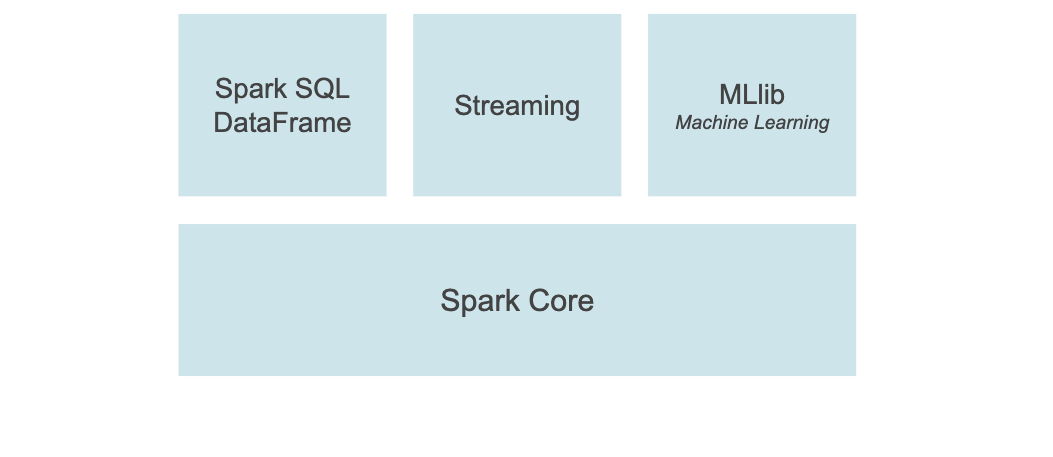

공식 문서 : https://spark.apache.org/docs/latest/api/python/#

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 56 kB/s 
     |████████████████████████████████| 199 kB 59.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=746280bf049512de9ac04f8b0452884d7045151aaaff06e7413eb13facfbc6bc
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


`SparkConf` : 사용자가 재정의해서 쓸 수 있는 설정 옵션들에 대한 키와 값을 갖고 있는 객체

`SparkContext` : Spark 클러스터와 연결시켜주는 객체
- Spark 모든 기능에 접근할 수 있는 시작점
- Spark는 분산환경에서 동작하기 때문에 Driver Program을 구동시키기 위해서 SparkContext가 필요
- SparkContext는 프로그램당 하나만 만들 수 있고 사용 후에는 종료해야함

`conf` : SparkContext를 초기화 하는데 쓰임

`setMaster("local")` : 분산된 환경이 아닌 로컬 환경을 사용

`setAppName("transformations_actions")` : 앱 이름을 transformations_actions로 설정 (Spark UI에서 확인 가능한 이름)

`sc` : sc라는 객체 생성
- *Naming Convention* : SparkContext로 만든 객체를 'sc'로 Naming 해줘야함

In [ ]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("transformations_actions")
sc = SparkContext(conf = conf)

In [ ]:
# SparkContext 설정 확인
sc.getConf().getAll()

##**Spark Operation = Transformations + Actions**##

####Transformations####
- 결과값으로 새로운 RDD 반환
- 지연 실행 Lazy Execution

####Actions####
- 결과값을 연산하여 출력하거나 저장
- Native Data값을 출력(List, Python Object 등)
- 즉시 실행 Eager Execution

####RDD 생성####
`parallelize` : Textfile처럼 RDD를 만드는데에 쓰임. 리스트로부터 RDD를 생성.

In [ ]:
# RDD 생성
foods = sc.parallelize(["짜장면","마라탕","짬뽕","떡볶이","쌀국수","짬뽕","짜장면","짜장면","짜장면","라면","우동","라면"])



---

##Actions##
- collect() : RDD 데이터를 모두 보여줌, *'값을 모두 가져올 수 있기 때문에 **디버깅이나 개발 환경에서만 사용하고 실제 프로덕트 상황에서는 지양.** 데이터를 모두 가져오기 때문에 너무 낭비가 됨'*
- countByValue() : 값의 개수를 key-value 형태로 보여줌
- take(n) : 상위 n개의 리스트를 보여줌
- first() : 첫번째 나오는 데이터 보여줌
- count() : element가 총 몇 개인지 카운팅
- foreach : 요소를 하나하나 꺼내 하나의 함수를 작용시키는데에 씀



In [ ]:
foods.collect()

['짜장면', '마라탕', '짬뽕', '떡볶이', '쌀국수', '짬뽕', '짜장면', '짜장면', '짜장면', '라면', '우동', '라면']

In [ ]:
foods.countByValue()

defaultdict(int,
            {'짜장면': 4,
             '마라탕': 1,
             '짬뽕': 2,
             '떡볶이': 1,
             '쌀국수': 1,
             '라면': 2,
             '우동': 1})

In [ ]:
foods.take(3)
foods.take(5)

['짜장면', '마라탕', '짬뽕', '떡볶이', '쌀국수']

In [ ]:
foods.first()

'짜장면'

In [ ]:
foods.count()

12

In [ ]:
# 유니크한 값 카운팅
foods.distinct().count()

7

여담 : 사실 **distinct()**는 Action이 아닌 **Transformation**임. type()을 통해 확인해보자!

In [ ]:
# Native Data 타입=>Actions의 결과, int
print(type(foods.count()))
print(type(foods.distinct().count()))

# RDD타입 => Transformations의 결과
print(type(foods.distinct()))

<class 'int'>
<class 'int'>
<class 'pyspark.rdd.PipelinedRDD'>


In [ ]:
# 값 리턴을 하지 않음
# Worker noded에서 실행됨
# 현재 SparkContext가 있는 Driver Program에 있기 때문에 실행 안됨
foods.foreach(lambda x:print(x))



---



##Transformations##
Transformation = Narrow + Wide



###Narrow Transformation###
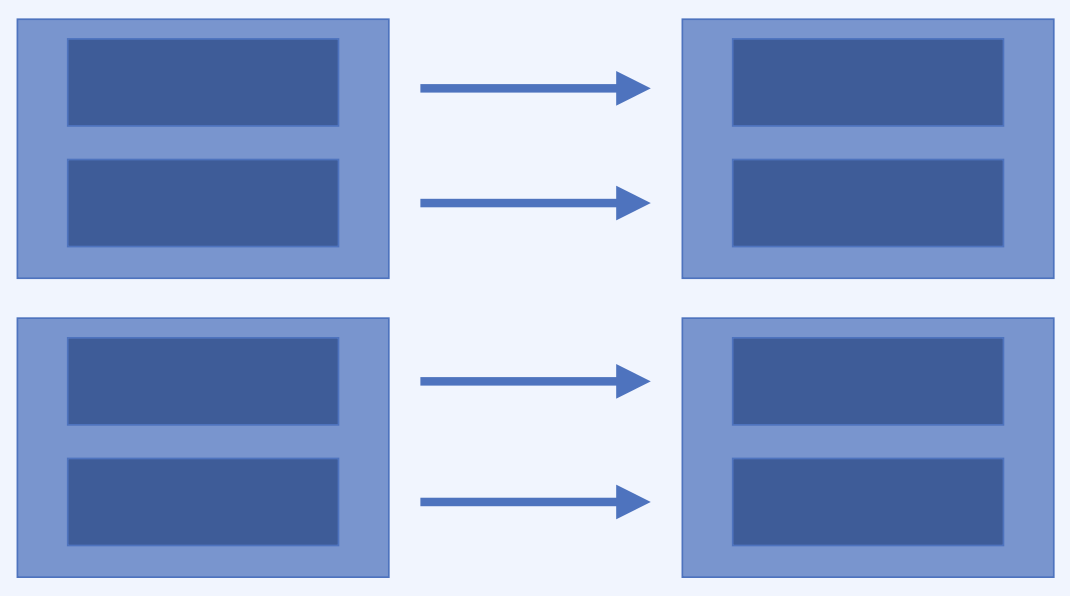
- 1:1 변환
- 다른 열/파티션의 데이터를 쓸 필요 없음
- 정렬이 필요하지 않은 경우
- 정렬 같은 경우 새로운 RDD를 만들 때 다른 열을 참고해야 함(많은 통신이 일어남), 그렇기 때문에 Narrow Transformation이 빠름
- 예시
  - filter() : 조건에 맞게 필터링
  - map() : RDD객체 반환
  - flatMap() : 1차원 RDD반환
  - sample() : 세가지 파라미터가 들어감. 밑 참조.
  - union() : 모든 값이 합쳐짐
  - subtract : 중복 데이터 사라짐

예시1

In [ ]:
# RDD 생성
movies =[
	"그린 북",
	"매트릭스",
	"토이 스토리",
	"캐스트 어웨이",
	"포드 V 페라리",
	"보헤미안 랩소디",
	"빽 투 더 퓨처",
	"반지의 제왕",
	"죽은 시인의 사회"
]

moviesRDD = sc.parallelize(movies)

In [ ]:
flatMovies = moviesRDD.flatMap(lambda x : x.split(" "))
flatMovies.collect()

In [ ]:
filteredMovies = moviesRDD.filter(lambda x : x!="매트릭스")
filteredMovies.collect()

예시 2

In [ ]:
# RDD 생성
num1 = sc.parallelize([1,2,3,4,5])
num2 = sc.parallelize([4,5,6,7,8,9,10])

In [ ]:
num1.union(num2).collect()

In [ ]:
num1.subtract(num2).collect()

`sample(True, .5, seed=6)`

True : 리샘플링 여부

.5 : 샘플링 할 비율

seed : seed로 샘플링한 값 고정


In [ ]:
numUnion = num1.union(num2)
numUnion.sample(True, .5, seed=2).collect()

[1, 1, 2, 4, 5, 5, 4, 5, 6, 7, 9]

예시 3 : map과 flatMap 비교

In [ ]:
# RDD 생성
rdd1 = sc.parallelize(['안녕 보아즈', 'BOAZ', '스파크', '엔지니어링 화이팅'])

print(rdd1.map(lambda x:x.split(' ')).collect())

# 1차원 반환
print(rdd1.flatMap(lambda x:x.split(' ')).collect())

[['안녕', '보아즈'], ['BOAZ'], ['스파크'], ['엔지니어링', '화이팅']]
['안녕', '보아즈', 'BOAZ', '스파크', '엔지니어링', '화이팅']


###Wide Transformation###
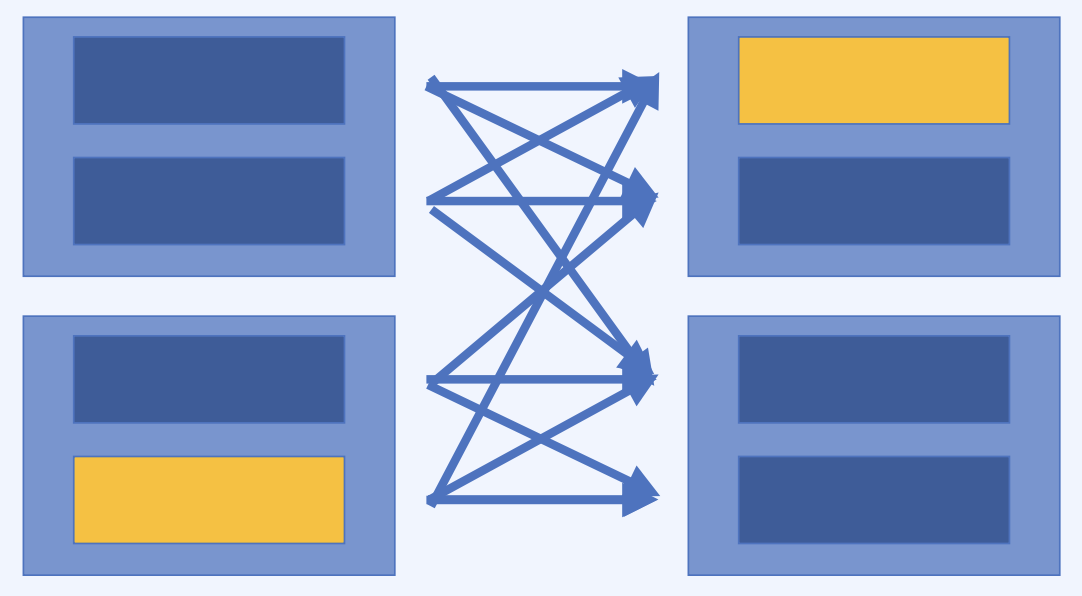
- 셔플링
- 아웃풋 파티션에 다른 파티션 데이터가 들어갈 수 있음
- 예시
  - intersection() : 겹치는 부분
  - join
  - distinct
  - reduceByKey()
  - groupByKey()
  등


In [ ]:
foodsGroup = foods.groupBy(lambda x : x[0])
res = foodsGroup.collect()

In [ ]:
for (k,v) in res:
  print(k, list(v))

In [ ]:
num1.intersection(num2).collect()

[4, 5]

In [ ]:
textRDD = sc.parallelize(['a','b','a','a','b','b','a','a','a','b','b','b'])

In [ ]:
# reduceByKey
textRDD.flatMap(lambda line:line.split()).map(lambda word:(word,1)).reduceByKey(lambda a,b:a+b).collect()

[('a', 6), ('b', 6)]

In [ ]:
# groupByKey


SyntaxError: ignored

In [ ]:
# 사용 후 종료!

# sc.stop()

In [ ]:
from pyspark import SparkConf, SparkContext
import pandas as pd

conf = SparkConf().setMaster("local").setAppName("uber-date-trips")
sc = SparkContext(conf=conf)

###Data : TLC Trip Record Data
- 10+년 이상의 택시와 모빌리티 서비스 기록
- 매년 20GB씩 쌓임
- https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

####데이터 정보
- hvfhs_license_num : 회사 면허 번호
- dispatching_base_num : 지역 라이센스 번호
- pickup_datetime : 승차 시간
- dropoff_datetime : 하차 시간
- PULocationID : 승차 지역 ID
- DOLocationID : 하차 지역 ID
- SR_Flag : 합승 여부 Flag

In [ ]:
# Data
lines = sc.textFile("/content/drive/MyDrive/Colab Notebooks/2022/BOAZ/학기 세션/fhvhv_tripdata_2020-03.csv")

# 헤더 지우기
header = lines.first()
filtered_lines = lines.filter(lambda row:row != header)

In [ ]:
dates = filtered_lines.map(lambda x:x.split(",")[2].split(" ")[0])
result = dates.countByValue()

In [ ]:
result

Reference


https://spark.apache.org/docs/latest/api/python/#